In [1]:
import pandas as pd
import numpy as np

In [3]:
# ローカルのファイルから読み込む
df_iris = pd.read_csv('iris.csv')

In [4]:
_x = df_iris.iloc[:, 0:4].values  # 入力変数
_t = df_iris.iloc[:, 4].values    # 教師データ

In [5]:
_x

array([[ 5.1,  3.5,  1.4,  0.2],
       [ 4.9,  3. ,  1.4,  0.2],
       [ 4.7,  3.2,  1.3,  0.2],
       [ 4.6,  3.1,  1.5,  0.2],
       [ 5. ,  3.6,  1.4,  0.2],
       [ 5.4,  3.9,  1.7,  0.4],
       [ 4.6,  3.4,  1.4,  0.3],
       [ 5. ,  3.4,  1.5,  0.2],
       [ 4.4,  2.9,  1.4,  0.2],
       [ 4.9,  3.1,  1.5,  0.1],
       [ 5.4,  3.7,  1.5,  0.2],
       [ 4.8,  3.4,  1.6,  0.2],
       [ 4.8,  3. ,  1.4,  0.1],
       [ 4.3,  3. ,  1.1,  0.1],
       [ 5.8,  4. ,  1.2,  0.2],
       [ 5.7,  4.4,  1.5,  0.4],
       [ 5.4,  3.9,  1.3,  0.4],
       [ 5.1,  3.5,  1.4,  0.3],
       [ 5.7,  3.8,  1.7,  0.3],
       [ 5.1,  3.8,  1.5,  0.3],
       [ 5.4,  3.4,  1.7,  0.2],
       [ 5.1,  3.7,  1.5,  0.4],
       [ 4.6,  3.6,  1. ,  0.2],
       [ 5.1,  3.3,  1.7,  0.5],
       [ 4.8,  3.4,  1.9,  0.2],
       [ 5. ,  3. ,  1.6,  0.2],
       [ 5. ,  3.4,  1.6,  0.4],
       [ 5.2,  3.5,  1.5,  0.2],
       [ 5.2,  3.4,  1.4,  0.2],
       [ 4.7,  3.2,  1.6,  0.2],
       [ 4

In [6]:
_t

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [7]:
# Chainer用に変数の型変換
x = np.array(_x, dtype=np.float32)
t = np.array(_t, dtype=np.int32)

In [8]:
x.shape

(150, 4)

In [9]:
t.shape

(150,)

In [10]:
# dataset用意(訓練データ、検証データ)
dataset = list(zip(x, t))

In [11]:
from chainer.datasets import split_dataset_random

n_train = int( len(dataset) * 0.7 )
train, test = split_dataset_random(dataset, n_train, seed=1)

# モデルの定義

In [12]:
import chainer
import chainer.links as L
import chainer.functions as F

In [14]:
# MLP: Multi-layer Perceptron
class MLP(chainer.Chain):
    
    def __init__(self, n_units1, n_units2, n_output):
        super().__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, n_units1)
            self.l2 = L.Linear(None, n_units2)
            self.l3 = L.Linear(None, n_output)
            
    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)

In [16]:
# モデルの宣言
np.random.seed(1) # 乱数のシードを固定

n_units1, n_units2, n_output = 10, 10, 3
mlp     = MLP(n_units1, n_units2, n_output)
model = L.Classifier(mlp)

In [17]:
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)

# Trainerの設定

In [18]:
# iteratorsの設定
batchsize = 20
train_iter = chainer.iterators.SerialIterator(train, batchsize)
test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)
# updaterの設定
from chainer import training
updater = training.StandardUpdater(train_iter, optimizer)
# trainerとそのextensionsの設定
from chainer.training import extensions

# trainerの基本設定
epoch = 1000
trainer = training.Trainer(updater, (epoch, 'epoch'), out='result')

# 評価データで評価
trainer.extend(extensions.Evaluator(test_iter, model))

# 学習結果の途中を表示する
trainer.extend(extensions.LogReport(trigger=(1, 'epoch')))

# １エポックごとに、trainデータに対するaccuracyと、testデータに対するaccuracyを出力させる
trainer.extend(extensions.PrintReport(['epoch', 'main/accuracy', 'validation/main/accuracy', 'elapsed_time']), trigger=(1, 'epoch'))

In [19]:
trainer.run()

epoch       main/accuracy  validation/main/accuracy  elapsed_time
1           0              0                         0.0552497     
2           0              0                         0.0842719     
3           0              0                         0.112915      
4           0              0                         0.130544      
5           0              0                         0.150918      
6           0              0                         0.168747      
7           0              0.0166667                 0.18286       
8           0.06           0.133333                  0.196119      
9           0.391667       0.65                      0.21173       
10          0.65           0.7                       0.225813      
11          0.65           0.7                       0.241336      
12          0.68           0.7                       0.25518       
13          0.675          0.716667                  0.281328      
14          0.67           0.7                    

123         0.99           0.983333                  2.38304       
124         0.98           0.983333                  2.39938       
125         0.983333       0.983333                  2.42273       
126         0.97           0.983333                  2.44215       
127         0.97           0.983333                  2.45901       
128         0.98           0.983333                  2.47621       
129         0.983333       0.983333                  2.49443       
130         0.97           0.983333                  2.51144       
131         0.98           0.983333                  2.52862       
132         0.98           0.983333                  2.54626       
133         0.966667       0.983333                  2.56617       
134         0.99           0.983333                  2.58517       
135         0.99           0.983333                  2.6023        
136         0.97           0.983333                  2.61911       
137         0.966667       0.983333             

241         0.991667       0.983333                  4.99655       
242         0.97           0.916667                  5.0233        
243         0.99           0.916667                  5.04538       
244         0.99           0.916667                  5.06855       
245         0.991667       0.916667                  5.09409       
246         0.99           0.916667                  5.1182        
247         0.99           0.916667                  5.14247       
248         0.99           0.916667                  5.16639       
249         0.991667       0.916667                  5.19367       
250         0.99           0.916667                  5.21991       
251         0.98           0.983333                  5.24727       
252         0.99           0.916667                  5.27387       
253         0.991667       0.9                       5.29778       
254         0.99           0.983333                  5.32017       
255         0.98           0.983333             

358         0.99           0.9                       7.98632       
359         0.99           0.916667                  8.02994       
360         0.99           0.916667                  8.07447       
361         0.983333       0.9                       8.13196       
362         1              0.9                       8.1712        
363         0.99           0.916667                  8.20393       
364         0.99           0.916667                  8.23065       
365         0.991667       0.9                       8.25661       
366         0.99           0.9                       8.28353       
367         0.99           0.9                       8.31215       
368         0.99           0.916667                  8.33749       
369         0.991667       0.9                       8.36281       
370         0.99           0.9                       8.38751       
371         0.99           0.9                       8.41341       
372         0.99           0.9                  

478         1              0.9                       13.7009       
479         0.99           0.9                       13.7399       
480         0.99           0.9                       13.7744       
481         0.991667       0.9                       13.8051       
482         0.99           0.9                       13.8494       
483         0.99           0.9                       13.8899       
484         0.99           0.9                       13.9352       
485         0.991667       0.9                       13.9796       
486         0.99           0.9                       14.0205       
487         0.99           0.9                       14.0583       
488         0.99           0.9                       14.0959       
489         0.991667       0.9                       14.1362       
490         0.99           0.9                       14.1752       
491         0.99           0.9                       14.2152       
492         0.99           0.9                  

594         1              0.9                       18.3509       
595         0.99           0.9                       18.3954       
596         0.99           0.9                       18.4334       
597         0.991667       0.9                       18.4749       
598         0.99           0.9                       18.516        
599         0.99           0.9                       18.5518       
600         0.99           0.9                       18.5857       
601         0.991667       0.9                       18.6358       
602         0.99           0.9                       18.6971       
603         0.99           0.9                       18.7566       
604         0.99           0.9                       18.7933       
605         0.991667       0.9                       18.8289       
606         0.99           0.9                       18.8724       
607         0.99           0.9                       18.9135       
608         0.99           0.9                  

711         1              0.9                       23.172        
712         0.99           0.9                       23.2127       
713         0.983333       0.9                       23.2672       
714         1              0.9                       23.3184       
715         0.99           0.9                       23.4015       
716         0.99           0.9                       23.4873       
717         0.983333       0.9                       23.5589       
718         1              0.9                       23.6063       
719         0.98           0.9                       23.6552       
720         1              0.9                       23.7034       
721         0.991667       0.9                       23.7657       
722         0.99           0.9                       23.804        
723         0.99           0.9                       23.8455       
724         0.99           0.9                       23.8878       
725         0.991667       0.9                  

828         0.99           0.9                       28.4831       
829         0.983333       0.9                       28.5303       
830         0.99           0.9                       28.5784       
831         1              0.9                       28.6206       
832         0.99           0.9                       28.6744       
833         0.991667       0.9                       28.7206       
834         0.99           0.9                       28.7819       
835         0.99           0.9                       28.8259       
836         0.99           0.9                       28.8667       
837         0.991667       0.9                       28.9087       
838         0.99           0.9                       28.9626       
839         0.99           0.9                       29.0203       
840         0.99           0.9                       29.0661       
841         0.991667       0.9                       29.1196       
842         0.99           0.9                  

945         0.991667       0.9                       34.1363       
946         0.99           0.9                       34.1864       
947         0.99           0.9                       34.2302       
948         0.99           0.9                       34.2758       
949         0.991667       0.9                       34.3219       
950         0.99           0.9                       34.3644       
951         0.99           0.9                       34.4172       
952         0.99           0.9                       34.4622       
953         0.991667       0.9                       34.5099       
954         0.98           0.9                       34.5537       
955         1              0.9                       34.597        
956         0.99           0.9                       34.6508       
957         0.991667       0.9                       34.7012       
958         0.99           0.9                       34.7516       
959         0.99           0.9                  

# 結果の確認

In [22]:
import matplotlib.pyplot as plt

In [23]:
import json

with open('result/log') as f:
     logs = json.load(f)

In [27]:
# 損失関数のプロット

In [28]:
loss_train = [ log['main/loss'] for log in logs ]
loss_test  = [ log['validation/main/loss'] for log in logs ]

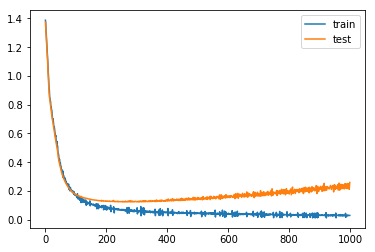

In [29]:
plt.plot(loss_train, label='train')  # 訓練データ
plt.plot(loss_test,  label='test')  # 検証データ
plt.legend()  # 凡例表示
plt.show()

In [31]:
# ↑オーバーフィッティングが生じている

In [32]:
# 正解率のプロット

In [33]:
accuracy_train = [ log['main/accuracy'] for log in logs ]
accuracy_test  = [ log['validation/main/accuracy'] for log in logs ]

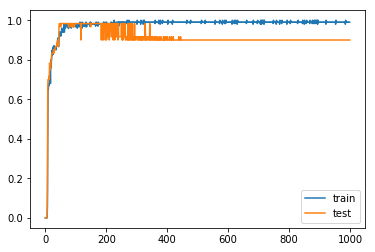

In [34]:
plt.plot(accuracy_train, label='train')  # 訓練データ
plt.plot(accuracy_test,  label='test')  # 検証データ
plt.legend()  # 凡例表示
plt.show()

# 予測値の計算

In [36]:
for datum in test:
    _x, _t = datum
    # クラスの予測値を計算
    y = mlp( np.array([_x]) )
    y = F.softmax(y).data
    index = np.argmax(y)
    # 結果の表示
    print('教師データ： ', _t,' 予測値: ', index)

教師データ：  0  予測値:  0
教師データ：  1  予測値:  1
教師データ：  0  予測値:  0
教師データ：  0  予測値:  0
教師データ：  2  予測値:  2
教師データ：  2  予測値:  2
教師データ：  2  予測値:  2
教師データ：  0  予測値:  0
教師データ：  0  予測値:  0
教師データ：  1  予測値:  2
教師データ：  0  予測値:  0
教師データ：  2  予測値:  2
教師データ：  0  予測値:  0
教師データ：  2  予測値:  2
教師データ：  2  予測値:  2
教師データ：  0  予測値:  0
教師データ：  2  予測値:  2
教師データ：  0  予測値:  0
教師データ：  1  予測値:  1
教師データ：  0  予測値:  0
教師データ：  1  予測値:  1
教師データ：  1  予測値:  1
教師データ：  0  予測値:  0
教師データ：  0  予測値:  0
教師データ：  1  予測値:  1
教師データ：  0  予測値:  0
教師データ：  1  予測値:  1
教師データ：  1  予測値:  1
教師データ：  0  予測値:  0
教師データ：  1  予測値:  1
教師データ：  1  予測値:  1
教師データ：  1  予測値:  1
教師データ：  1  予測値:  1
教師データ：  2  予測値:  2
教師データ：  0  予測値:  0
教師データ：  0  予測値:  0
教師データ：  2  予測値:  2
教師データ：  1  予測値:  1
教師データ：  2  予測値:  1
教師データ：  1  予測値:  1
教師データ：  2  予測値:  1
教師データ：  2  予測値:  2
教師データ：  1  予測値:  1
教師データ：  2  予測値:  2
教師データ：  0  予測値:  0


## コメント
過学習が起きているものの、ある程度はうまく分類できている

# オーバーフィッティング対策
ドロップアウトを入れることで、オーバーフィッティングが防げるか試す

In [53]:
# MLP: Multi-layer Perceptron
class MLP(chainer.Chain):
    
    def __init__(self, n_units1, n_units2, n_output):
        super().__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, n_units1)
            self.l2 = L.Linear(None, n_units2)
            self.l3 = L.Linear(None, n_output)
            
    def __call__(self, x, train=True):
        if train:
            h1 = F.dropout( F.relu(self.l1(x)), ratio=0.2)
            h2 = F.dropout( F.relu(self.l2(h1)), ratio=0.2 )
            return self.l3(h2)
        else:
            h1 = F.relu(self.l1(x))
            h2 = F.relu(self.l2(h1))
            return self.l3(h2)

In [54]:
# モデルの宣言
np.random.seed(1) # 乱数のシードを固定

n_units1, n_units2, n_output = 10, 10, 3
mlp     = MLP(n_units1, n_units2, n_output)
model = L.Classifier(mlp)

In [55]:
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)

In [56]:
# iteratorsの設定
batchsize = 20
train_iter = chainer.iterators.SerialIterator(train, batchsize)
test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)
# updaterの設定
from chainer import training
updater = training.StandardUpdater(train_iter, optimizer)
# trainerとそのextensionsの設定
from chainer.training import extensions

# trainerの基本設定
epoch = 1000
trainer = training.Trainer(updater, (epoch, 'epoch'), out='result')

# 評価データで評価
trainer.extend(extensions.Evaluator(test_iter, model))

# 学習結果の途中を表示する
trainer.extend(extensions.LogReport(trigger=(1, 'epoch')))

# １エポックごとに、trainデータに対するaccuracyと、testデータに対するaccuracyを出力させる
trainer.extend(extensions.PrintReport(['epoch', 'main/accuracy', 'validation/main/accuracy', 'elapsed_time']), trigger=(1, 'epoch'))

In [57]:
trainer.run()

epoch       main/accuracy  validation/main/accuracy  elapsed_time
1           0.391667       0.633333                  0.0194199     
2           0.39           0.633333                  0.0495965     
3           0.42           0.633333                  0.0800166     
4           0.48           0.616667                  0.101568      
5           0.458333       0.616667                  0.121303      
6           0.46           0.6                       0.138638      
7           0.5            0.866667                  0.154635      
8           0.43           0.85                      0.169901      
9           0.533333       0.783333                  0.18636       
10          0.57           0.733333                  0.201503      
11          0.57           0.716667                  0.216194      
12          0.44           0.7                       0.233279      
13          0.583333       0.7                       0.255639      
14          0.51           0.7                    

120         0.82           0.983333                  2.75324       
121         0.866667       0.983333                  2.779         
122         0.84           0.983333                  2.80587       
123         0.81           0.983333                  2.82664       
124         0.82           0.983333                  2.84605       
125         0.841667       0.983333                  2.8669        
126         0.79           0.983333                  2.88639       
127         0.86           0.983333                  2.90535       
128         0.78           0.983333                  2.95302       
129         0.85           0.916667                  2.98961       
130         0.87           0.916667                  3.02465       
131         0.88           0.983333                  3.06327       
132         0.86           0.983333                  3.09796       
133         0.758333       0.983333                  3.13049       
134         0.83           0.983333             

238         0.81           0.983333                  6.33128       
239         0.78           0.983333                  6.36128       
240         0.88           0.966667                  6.39066       
241         0.883333       0.9                       6.42063       
242         0.9            0.9                       6.44566       
243         0.82           0.9                       6.47371       
244         0.91           0.9                       6.50282       
245         0.858333       0.983333                  6.5354        
246         0.85           0.983333                  6.57175       
247         0.91           0.983333                  6.61018       
248         0.87           0.983333                  6.65602       
249         0.825          0.983333                  6.70944       
250         0.87           0.9                       6.75954       
251         0.86           0.9                       6.80295       
252         0.92           0.9                  

358         0.91           0.9                       10.5706       
359         0.9            0.9                       10.5995       
360         0.91           0.9                       10.6296       
361         0.9            0.9                       10.6628       
362         0.93           0.9                       10.6919       
363         0.92           0.9                       10.72         
364         0.85           0.983333                  10.7529       
365         0.866667       0.983333                  10.7836       
366         0.87           0.9                       10.8154       
367         0.91           0.9                       10.854        
368         0.9            0.9                       10.8851       
369         0.883333       0.9                       10.9345       
370         0.91           0.9                       10.9664       
371         0.91           0.983333                  10.9957       
372         0.84           0.983333             

475         0.9            0.9                       14.5444       
476         0.94           0.9                       14.5822       
477         0.916667       0.9                       14.6222       
478         0.96           0.9                       14.6552       
479         0.96           0.9                       14.6852       
480         0.91           0.9                       14.7159       
481         0.9            0.916667                  14.7484       
482         0.92           0.9                       14.7884       
483         0.89           0.9                       14.8248       
484         0.92           0.9                       14.8572       
485         0.95           0.9                       14.9046       
486         0.93           0.9                       14.9397       
487         0.94           0.9                       14.9764       
488         0.92           0.9                       15.0197       
489         0.908333       0.9                  

596         0.91           0.916667                  19.2433       
597         0.941667       0.9                       19.2858       
598         0.92           0.9                       19.325        
599         0.97           0.9                       19.358        
600         0.95           0.9                       19.3912       
601         0.916667       0.9                       19.4239       
602         0.93           0.9                       19.4559       
603         0.93           0.9                       19.4899       
604         0.96           0.9                       19.5283       
605         0.958333       0.9                       19.5644       
606         0.97           0.9                       19.6001       
607         0.94           0.9                       19.6342       
608         0.91           0.9                       19.6695       
609         0.908333       0.9                       19.7057       
610         0.95           0.9                  

714         0.92           0.9                       25.2467       
715         0.94           0.9                       25.2902       
716         0.94           0.9                       25.3299       
717         0.966667       0.9                       25.3727       
718         0.96           0.9                       25.4179       
719         0.96           0.9                       25.4732       
720         0.96           0.9                       25.5434       
721         0.941667       0.9                       25.611        
722         0.96           0.9                       25.6658       
723         0.97           0.9                       25.7136       
724         0.95           0.9                       25.7737       
725         0.925          0.9                       25.8443       
726         0.96           0.9                       25.9148       
727         0.95           0.9                       25.9921       
728         0.94           0.916667             

831         0.97           0.9                       31.6361       
832         0.94           0.9                       31.7146       
833         0.958333       0.916667                  31.7774       
834         0.96           0.916667                  31.8411       
835         0.98           0.916667                  31.9079       
836         0.95           0.916667                  31.9948       
837         0.95           0.9                       32.0684       
838         0.95           0.9                       32.1145       
839         0.94           0.9                       32.1732       
840         0.95           0.9                       32.2308       
841         0.975          0.9                       32.2855       
842         0.96           0.9                       32.3311       
843         0.97           0.9                       32.3739       
844         0.94           0.9                       32.4171       
845         0.95           0.9                  

947         0.96           0.9                       38.138        
948         0.97           0.9                       38.2059       
949         0.958333       0.9                       38.2559       
950         0.96           0.9                       38.3007       
951         0.97           0.916667                  38.3527       
952         0.98           0.9                       38.4054       
953         0.966667       0.9                       38.4627       
954         0.95           0.9                       38.5192       
955         0.97           0.9                       38.5772       
956         0.97           0.916667                  38.6454       
957         0.958333       0.916667                  38.696        
958         0.92           0.9                       38.7606       
959         0.98           0.9                       38.8341       
960         0.94           0.9                       38.9032       
961         0.975          0.9                  

# 結果の確認

In [59]:
import json

with open('result/log') as f:
     logs = json.load(f)

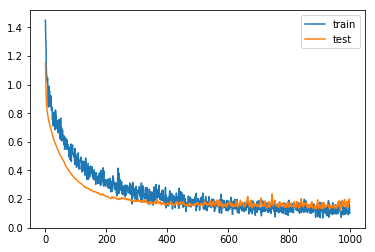

In [60]:
# 損失関数のプロット
loss_train = [ log['main/loss'] for log in logs ]
loss_test  = [ log['validation/main/loss'] for log in logs ]

plt.plot(loss_train, label='train')  # 訓練データ
plt.plot(loss_test,  label='test')  # 検証データ
plt.legend()  # 凡例表示
plt.show()

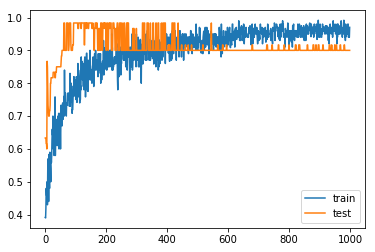

In [63]:
# 正解率のプロット
accuracy_train = [ log['main/accuracy'] for log in logs ]
accuracy_test  = [ log['validation/main/accuracy'] for log in logs ]

plt.plot(accuracy_train, label='train')  # 訓練データ
plt.plot(accuracy_test,  label='test')  # 検証データ
plt.legend()  # 凡例表示
plt.show()

# 予測値の計算

In [62]:
for datum in test:
    _x, _t = datum
    # クラスの予測値を計算
    y = mlp( np.array([_x]) )
    y = F.softmax(y).data
    index = np.argmax(y)
    # 結果の表示
    print('教師データ： ', _t,' 予測値: ', index)

教師データ：  0  予測値:  0
教師データ：  1  予測値:  1
教師データ：  0  予測値:  0
教師データ：  0  予測値:  0
教師データ：  2  予測値:  2
教師データ：  2  予測値:  2
教師データ：  2  予測値:  2
教師データ：  0  予測値:  0
教師データ：  0  予測値:  0
教師データ：  1  予測値:  2
教師データ：  0  予測値:  0
教師データ：  2  予測値:  2
教師データ：  0  予測値:  0
教師データ：  2  予測値:  2
教師データ：  2  予測値:  2
教師データ：  0  予測値:  0
教師データ：  2  予測値:  2
教師データ：  0  予測値:  0
教師データ：  1  予測値:  1
教師データ：  0  予測値:  0
教師データ：  1  予測値:  1
教師データ：  1  予測値:  1
教師データ：  0  予測値:  0
教師データ：  0  予測値:  0
教師データ：  1  予測値:  1
教師データ：  0  予測値:  0
教師データ：  1  予測値:  1
教師データ：  1  予測値:  1
教師データ：  0  予測値:  0
教師データ：  1  予測値:  1
教師データ：  1  予測値:  1
教師データ：  1  予測値:  1
教師データ：  1  予測値:  1
教師データ：  2  予測値:  2
教師データ：  0  予測値:  0
教師データ：  0  予測値:  0
教師データ：  2  予測値:  2
教師データ：  1  予測値:  1
教師データ：  2  予測値:  1
教師データ：  1  予測値:  1
教師データ：  2  予測値:  1
教師データ：  2  予測値:  2
教師データ：  1  予測値:  1
教師データ：  2  予測値:  2
教師データ：  0  予測値:  0


## コメント
検証用データに対しては、それほど結果は変わらないが、オーバーフィッティングの現象を防げていることがわかる。